# 실습 과제 #3. MLP 모델 만들기 w/ Numpy

> 2023년도 2학기 데이터애널리틱스 (JEO01425-0856)
> <br>2023년 10월 17일 ~ 2023년 10월 30일

- **실습 개요**
<br>6~7주차에서 학습한 개념들을 토대로 MLP 모델을 만들어 MNIST 데이터셋을 분류해봅니다.

- **문제 개요**
<br>이번 과제는 과제#1 또는 과제#2와 다르게 대부분의 코드가 주어져 있습니다.
<br>따라서 주어진 코드를 잘 읽고, 이해하는 쪽에 초점을 맞추어 과제를 수행하시면 됩니다.
<br><br>기존 과제와 마찬가지로 파트너와 함께 진행하면 되나, 작성해야 하는 부분이 많지 않은 만큼
<br>최대한 혼자서 해결해본 뒤 최종적으로 파트너와 함께 코드를 검토하는 것을 추천드립니다.
<br><br>과제를 수행해야 하는 블록에는 **<font color=#5F71F7>과제 ASSIGNMENT</font>** 라는 키워드로 표시해두었습니다.
<br><code><font color=#008000># TODO: ... #</font></code>라고 쓰여 있는 부분을 해당 주석의 설명에 맞게 채워주시면 됩니다. (각 10점)

- **전체 목차**

1. MNIST 데이터셋 불러오기
<br><br>
2. 간단한 MLP 모델 구현하기
    - 2.1. 활성화 함수 구현하기
    - 2.2. MLP 레이어 구현하기
    - 2.3. 손실 함수 구현하기
    - 2.4. MLP 모델 구현하기
<br><br>
3. 모델 학습하기
    - 3.1. 모델 학습을 위한 함수 구현하기
    - 3.2. 모델 학습하기
<br><br>
4. 결과 시각화하기
    - 4.1. 학습 과정 시각화하기
    - 4.2. 최종 결과 시각화하기

---

### 데이터셋 개요

<div align="center">
<img src="https://upload.wikimedia.org/wikipedia/commons/f/f7/MnistExamplesModified.png" alt="MNIST Test Data Samples">
</div>


- 데이터셋 :
MNIST(Modified National Institute of Standards and Technology) Database
<br><br>
- 데이터셋 개요 :
<br>&ensp;&ensp;MNIST 데이터셋은 미국의 NIST에서 이미지 처리 시스템을 위해 모은 손글씨 이미지 데이터셋 중 일부를 재구성한 것으로,
<br>0부터 9까지의 숫자 이미지와 이에 대응되는 한 자리 숫자가 한 쌍으로 구성되어 있습니다.
<br><br>
- 데이터셋 구성
  - 입력(이미지) : 0부터 9까지의 숫자 중 하나에 속하는 28px * 28px의 흑백 이미지
  - 출력(숫자) : 주어진 이미지에 대응되는 숫자 (0~9)
<br><br>
- 데이터 샘플 수
  - 학습 데이터&ensp;&ensp;: 60,000 개
  - 테스트 데이터&thinsp;: 10,000 개
<br><br>
- 데이터셋 저작권: [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/)



---

## 0. 환경 설정

본 실습에서 사용하는 라이브러리는 아래와 같습니다.
- 모델 학습 및 결과 시각화 필요한 라이브러리
    - numpy : 행렬 연산에 필요한 라이브러리. MNIST 데이터를 불러오고, 모델을 정의하는 데에 사용.
    - matplotlib : 대표적인 시각화 라이브러리. 학습 결과를 시각화하는데 사용.
    - tqdm : for문의 진행 상태를 표시하는데 사용하는 라이브러리. 학습 시간 및 진행 상태를 확인하는데 사용.
<br><br>
- 각종 유틸리티 라이브러리
    - os : 파일 경로를 확인하는데 사용하는 라이브러리.
    - random : 데이터를 랜덤하게 섞는데 사용하는 라이브러리.
    - utils.py : MNIST 데이터를 불러와서 전처리하는 함수가 정의되어 있는 모듈.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
import random
from utils import load_mnist

In [3]:
# 재현성을 위한 시드 고정
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

In [4]:
# 주요 라이브러리 버전 확인
from importlib.metadata import version
print("numpy version : {}".format(version("numpy")))
print("matplotlib version : {}".format(version("matplotlib")))

numpy version : 1.23.5
matplotlib version : 3.7.1


In [5]:
# matplotlib의 해상도 높이기
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. MNIST 데이터셋 불러오기

<code>💡 [ 개요 ]  
<p>&emsp;&emsp;&emsp;MNIST 데이터셋은 워낙 유명한 만큼, 다양한 방법을 통해 파이썬에서 불러올 수 있습니다.
<br>&emsp;&emsp;&emsp;MNIST 데이터셋을 사용하는 방법은 크게 두 가지로,
<br>&emsp;&emsp;&emsp;하나는 직접 다운받아 가공하는 방법이며 다른 하나는 라이브러리를 통해 불러오는 방법입니다.</p>
<p>&emsp;&emsp;&emsp;본 실습에서는 전자의 방법을 사용하고 있으며,
<br>&emsp;&emsp;&emsp;코드가 길어지는 것을 방지하기 위해 전부 `utils.py`에 작성하였습니다.</p>
</code>

### 1.1. 데이터셋 불러오기 (`utils.py` 참고)

- 일반적인 딥러닝 파이프라인에서는 학습 데이터를 다시 둘로 쪼개어 검증 데이터를 확보해야 하지만,
<br>이번 실습에서는 검증 데이터가 크게 필요하지 않으므로 해당 과정을 생략합니다.

In [6]:
# 데이터셋을 불러올 경로 지정
dataset_dir = os.path.join(os.getcwd(), 'data')

# TODO: utils.py 모듈 내의 `load_mnist()` 함수를 이용하여 학습/테스트 데이터셋을 불러오기
X_train, y_train = load_mnist(dataset_dir, kind='train') # `load_mnist()` 함수를 이용하여 학습 데이터셋 불러오기
X_test, y_test = load_mnist(dataset_dir, kind='test') # `load_mnist()` 함수를 이용하여 테스트 데이터셋 불러오기

Downloaded train-images-idx3-ubyte.gz to /content/data
Downloaded train-labels-idx1-ubyte.gz to /content/data
Downloaded t10k-images-idx3-ubyte.gz to /content/data
Downloaded t10k-labels-idx1-ubyte.gz to /content/data


### 1.2. 데이터셋 확인하기

In [7]:
# 최종 데이터셋의 형태 확인
print('X_train의 형태 : {}'.format(X_train.shape))
print('y_train의 형태 : {}'.format(y_train.shape))
print('X_test의 형태  : {}'.format(X_test.shape))
print('y_test의 형태  : {}'.format(y_test.shape))

X_train의 형태 : (60000, 784)
y_train의 형태 : (60000, 10)
X_test의 형태  : (10000, 784)
y_test의 형태  : (10000, 10)


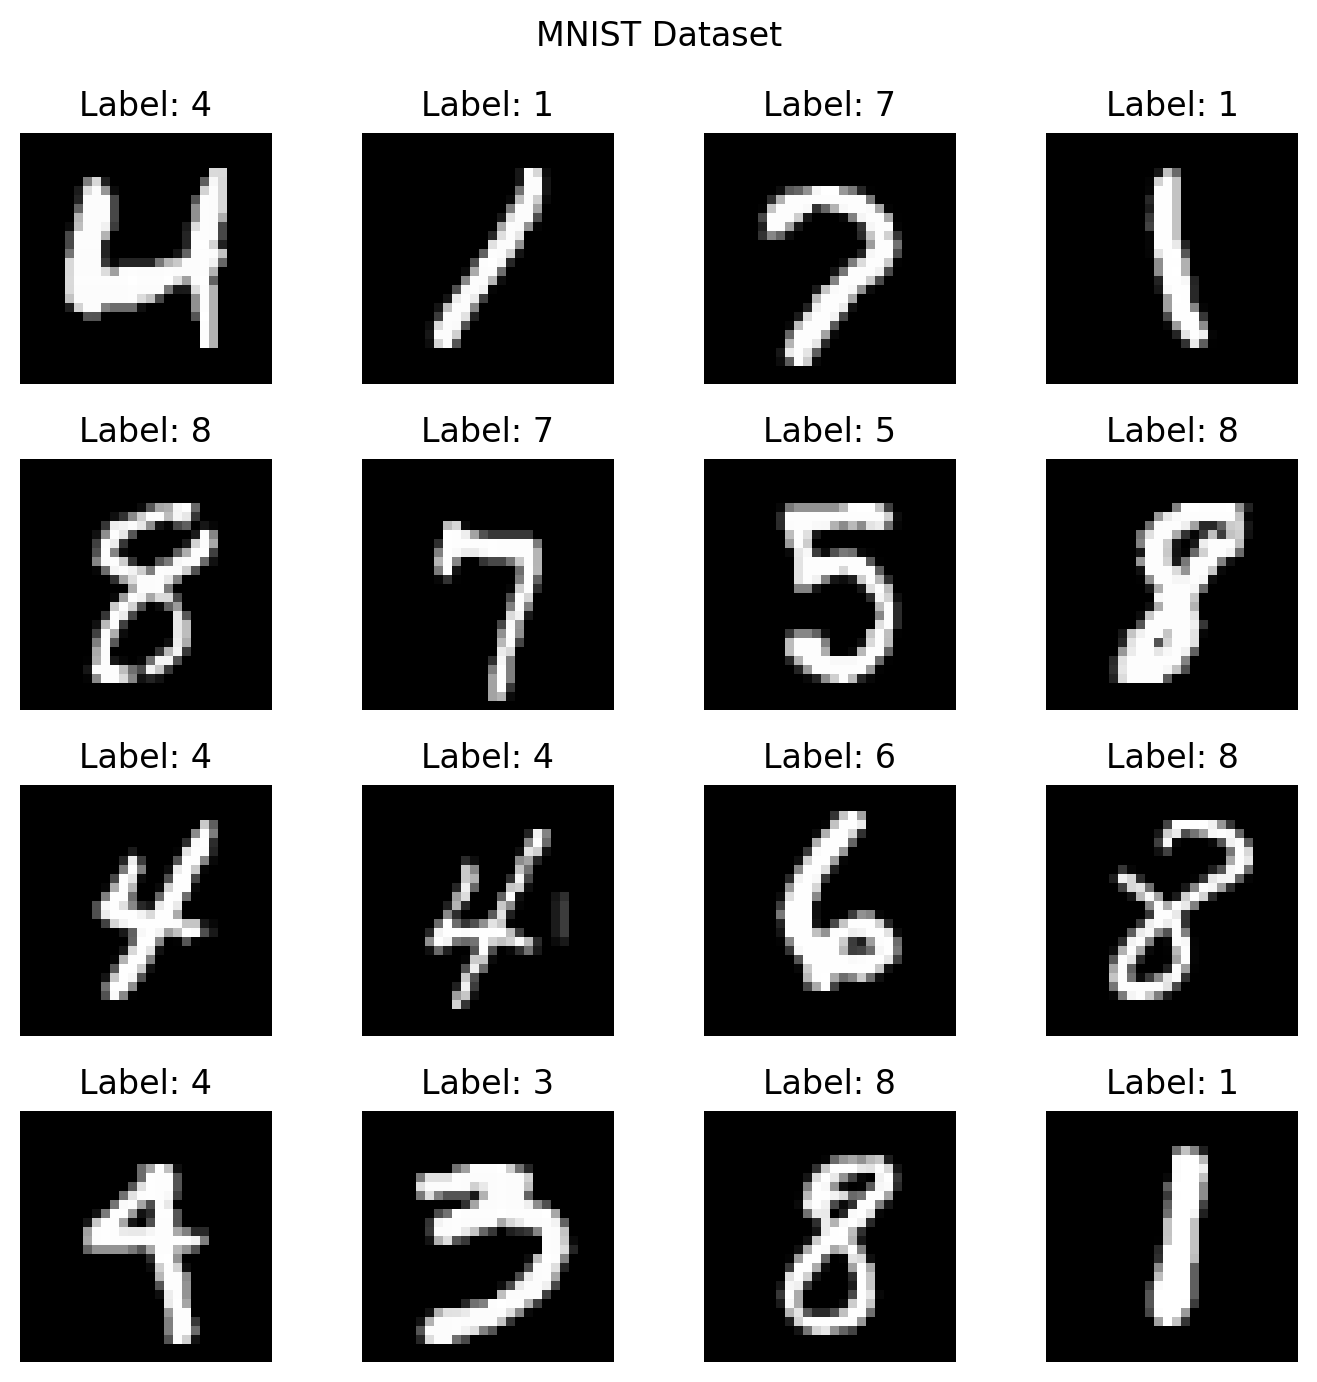

In [8]:
# 학습 데이터 내의 임의의 16개 샘플 살펴보기

# 7x7 사이즈의 새로운 figure 생성
plt.figure(figsize=(7,7))
# 16개의 랜덤한 정수 생성
random_indices = np.random.randint(0, len(X_train), size=16)

# 16개의 랜덤한 정수에 해당하는 이미지를 4x4 그리드에 하나씩 출력
for n, idx in enumerate(random_indices, start=1):
    # 4x4 그리드의 n번째 위치를 지정
    # 해당 위치에 그레이스케일 이미지를 출력하고, 타이틀로는 라벨 값을 출력
    # x축과 y축이 필요하지 않으므로 눈금 출력 생략
    plt.subplot(4,4,n)
    plt.imshow(X_train[idx].reshape(28,28), cmap='gray')
    plt.title(f"Label: {y_train[idx].argmax()}")
    plt.axis('off')

plt.suptitle('MNIST Dataset')
plt.tight_layout()
plt.show()

---

## 2. 간단한 MLP 모델 구현하기

<code>💡 [ 개요 ]  
<p>&emsp;&emsp;&emsp;numpy 라이브러리만으로 다층 퍼셉트론(MLP)을 구현하는 방법을 습득합니다.</p>
<p>&emsp;&emsp;&emsp;전체 모델을 구성하기에 앞서 여러 구성요소들이 필요합니다.
<br>&emsp;&emsp;&emsp;이 때, 각각의 구성요소들을 구현할 때에는 필연적으로 학습을 위한 도함수도 함께 정의되어야 합니다.
<br>&emsp;&emsp;&emsp;각 구성요소의 순전파를 `forward`라는 이름으로, 역전파를 `backward`라는 이름으로 만들겠습니다.</p>
</code>

- 2.1. 활성화 함수 구현하기 &ensp;&ensp;$\cdots$ &ensp;`Sigmoid`
- 2.2. MLP 레이어 구현하기 &ensp;$\cdots$ &ensp;`FCLayer`
- 2.3. 손실 함수 구현하기 &emsp;&ensp;&nbsp;$\cdots$ &ensp;`MSELoss`, `CrossEntropyLoss`
- 2.4. MLP 모델 구현하기 &emsp;&ensp;$\cdots$ &ensp;`MLP`


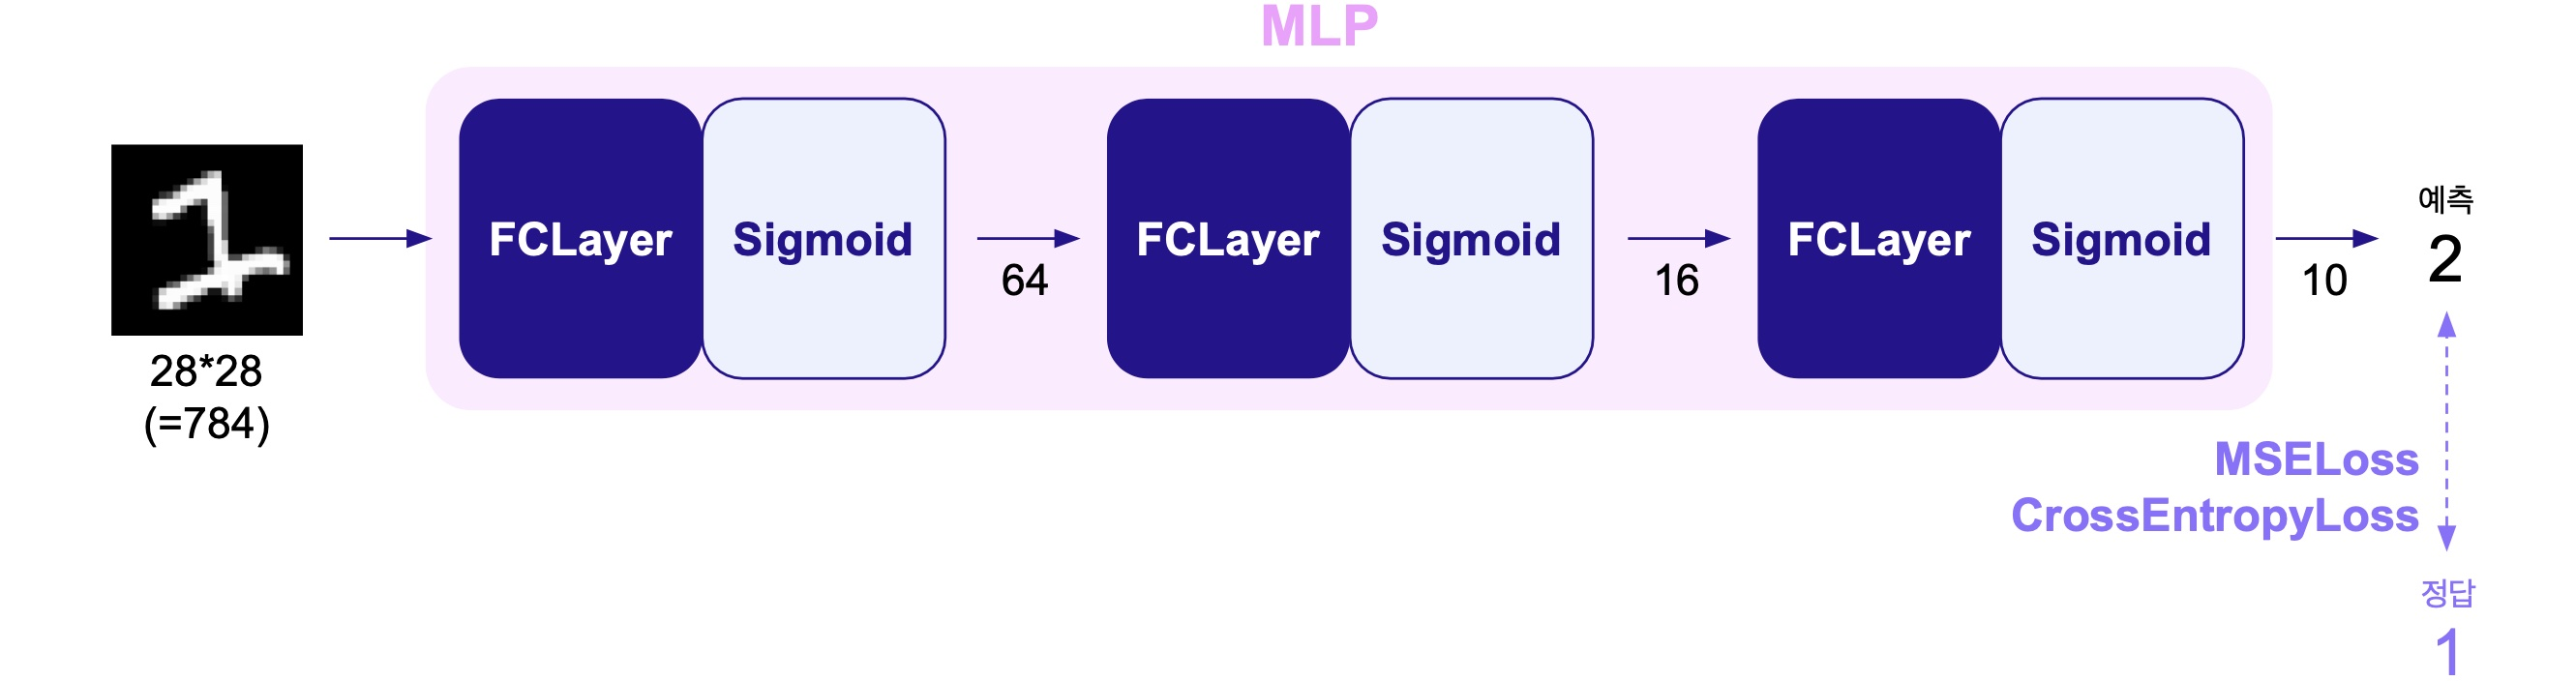


### 2.1. 활성화 함수 구현하기

<code>💡 [ 개요 ]  
<p>&emsp;&emsp;&emsp;모델을 구성하는 데에 있어 중요한 부분인 활성화 함수(activation function)를 구현합니다.
<br>&emsp;&emsp;&emsp;여러 활성화 함수가 있지만, 여기서는 시그모이드 함수만을 구현합니다.</p>
</code>

- 2.1.1. 시그모이드 함수 및 도함수의 수식
- 2.1.2. 시그모이드 함수의 구현
- 2.1.3. 시그모이드 레이어의 구현
- 2.1.4. 시그모이드 레이어 테스트하기

#### 2.1.1. 시그모이드 함수 및 도함수의 수식

$$ f = \frac{1}{1 + e^{-x}}$$

$$ \frac{\partial f}{\partial x} = \left(1.0 - f(x) \right) f(x) $$


#### 2.1.2. 시그모이드 함수의 구현
- 위의 수식을 함수 형태로 각각 구현하면 아래와 같이 구현될 것입니다.

In [9]:
def sigmoid(x):
    '''시그모이드 함수'''
    return 1 / (1 + np.exp(-x))

In [10]:
def sigmoid_prime(x):
    '''시그모이드 함수의 그래디언트'''
    return (1.0 - sigmoid(x)) * sigmoid(x)

#### 2.1.3. 시그모이드 레이어의 구현

- 그러나 실제로 모델에 사용하기 위해서는 레이어 형태로 구현해야 합니다.
    - 레이어 형태로 구현하면, 아래와 같이 변형됩니다.
<br><br>
- 코드를 잘 살펴보아야 뒤 이은 과제를 수행하기 쉬울 것입니다.
    - `forward` 함수는 입력값을 받아서 시그모이드 함수를 적용한 값을 반환합니다.
    <br>이 때, 향후 이 결과물이 다시 쓰일 수 있으므로 이를 `self.out`에 저장합니다.
    - `backward` 함수는 입력값으로 들어온 미분값에 시그모이드 함수의 도함수를 곱하여 반환합니다.
    <br>이 때 중요한 점은, 위의 `sigmoid_prime` 함수와 달리, 미리 저장해둔 `self.out`을 사용한다는 점입니다.
    - 또한, 지금 우리는 출력 레이어서부터 입력 레이어까지 거꾸로 역전파를 진행하고 있습니다.
    <br>즉, 다음 레이어에서 받아온 미분값에 현재 레이어의 미분값을 곱하여 다음 레이어로 전달해야 합니다.
    <br>따라서 다음 레이어의 미분 값인 dout을 곱해서 반환해야 합니다.

In [11]:
class Sigmoid():
    '''시그모이드 레이어 (시그모이드 함수의 클래스 버전)'''
    def __init__(self):
        self.out = None

    def forward(self, x):
        '''시그모이드 레이어의 순전파(forward propagation)'''
        # 순전파가 흐를 시 그 결과물을 attribute로 저장 및 리턴
        self.out = sigmoid(x)
        return self.out

    def backward(self, dout):
        '''시그모이드 레이어의 역전파(backpropagation)'''
        # 역전파가 흐를시 그 그래디언트 값을 리턴
        dx = dout * (1.0 - self.out) * self.out
        return dx

#### 2.1.4. 시그모이드 레이어 테스트하기

- 임의로 생성한 변수를 이용하여, 시그모이드 레이어가 문제 없이 실행되는지 확인해봅시다.

In [12]:
# 시그모이드 레이어의 순전파/역전파가 잘 작동하는지 테스트
# 임의의 사이즈에 대해 모두 동일한 크기의 결과가 출력되어야 하며, 각각 단순하게 시그모이드 함수를 적용한 값과 도함수를 적용한 값이 된다면 성공
# 직접 x값을 시그모이드 함수에 넣어서 결과가 같은지 확인해볼 수 있음

x = np.random.randn(5, 2)
print('x =\n', x)

sigmoid_layer = Sigmoid()
print('\nsigmoid_layer.forward(x) =\n', sigmoid_layer.forward(x))
print('\nsigmoid_layer.backward(1) =\n', sigmoid_layer.backward(1)) # 다음 레이어의 미분값이 1일 경우 역전파의 결과

x =
 [[-0.10321885  0.4105985 ]
 [ 0.14404357  1.45427351]
 [ 0.76103773  0.12167502]
 [ 0.44386323  0.33367433]
 [ 1.49407907 -0.20515826]]

sigmoid_layer.forward(x) =
 [[0.47421817 0.60123138]
 [0.53594876 0.81065526]
 [0.68157899 0.53038128]
 [0.60917918 0.58265313]
 [0.81668973 0.44888958]]

sigmoid_layer.backward(1) =
 [[0.2493353  0.23975221]
 [0.24870769 0.15349331]
 [0.21702907 0.24907698]
 [0.23807991 0.24316846]
 [0.14970761 0.24738772]]


### 2.2. MLP 레이어 구현하기

<code>💡 [ 개요 ]  
<p>&emsp;&emsp;&emsp;MLP 모델의 각 층을 구성하는 MLP 레이어를 구현합니다.
<br>&emsp;&emsp;&emsp;이 레이어는 fully-connected layer, linear layer, dense layer 등으로 불리고 있습니다.
<br>&emsp;&emsp;&emsp;나중에 여러분이 사용하게 될 PyTorch에서는 `torch.nn.Linear`라는 이름으로 구현되어 있습니다.
<br>&emsp;&emsp;&emsp;본 과제에서는 `FCLayer`라는 이름의 클래스로 구현해보겠습니다.</p>

</code>

- 2.2.1. FCLayer 클래스 구현하기
- 2.2.2. FCLayer 클래스 테스트하기


#### 2.2.1. FCLayer 클래스 구현하기

- MLP 모델의 절반(?)이라고 할 수 있는 활성화함수는 이전 단락에서 구현했습니다.
<br><br>
- 따라서 본 단락에서는 $ z^l = W\cdot a^{l-1} + b$ 의 연산을 수행하는 레이어를 구현하기만 하면 됩니다.
- **7주차 강의자료 p108에 적힌 $\partial C / \partial b$, $\partial C / \partial w$에 대한 내용**을 코드로 구현하는 부분입니다.
    - $z^l$ : $l$번째 레이어의 출력값, 즉 `out`
    - $\delta^l$ : $l$번째 레이어의 미분값, 즉 `dout`
    - $a^{l-1}$ : $l$번째 레이어의 입력값, 즉 `self.x`
<br><br>
- **우선 주석에 있는 내용을 읽어보고 주어진 주석의 설명을 어떻게 행렬곱으로 나타내면 좋을지 고민해보세요.**
- 잘 모르겠다면 github에 올라와 있는 코드들을 참고해보세요. <br>(워낙 기본적인 코드라 약간의 검색만으로도 충분히 찾아낼 수 있습니다!!)

In [13]:
class FCLayer():
    '''완전 연결 레이어 (Fully-Connected Layer, FC Layer)'''
    def __init__(self, input_size, output_size):
        '''가중치와 편향 초기화
        input_size: 입력 데이터의 차원 수
        output_size: 출력 데이터의 차원 수
        weight_init_std: 가중치 초기화 시 사용하는 표준 편차'''

        # 가중치는 정규분포를 따르는 난수로 초기화
        self.W = np.random.randn(input_size, output_size)
        # 편향도 정규분포를 따르는 난수로 초기화
        self.b = np.random.randn(output_size)

        # 역전파 계산을 위해 입력 데이터 저장
        self.x = None
        # 모델 학습을 위해 가중치와 편향의 그래디언트 저장
        self.dW = None
        self.db = None


    def forward(self, x):
        '''완전 연결 레이어의 순방향 전파(forward propagation)'''
        # 역전파 계산을 위해 입력 데이터 저장
        self.x = x
        # TODO: out을 완성해주세요. (힌트 : out = Wx + b)
        out = np.dot(x, self.W) + self.b

        return out

    def backward(self, dout):
        '''완전 연결 레이어의 역방향 전파(backward propagation; 역전파)'''
        # TODO: dx를 완성해주세요. (힌트 : dout/dx = W  ->  dx = dout * W)
        dx = np.dot(dout, self.W.T)
        # TODO: self.dW를 완성해주세요. (힌트 : dout/dW = x  ->  dW = dout * x)
        self.dW = np.dot(self.x.T, dout)
        # TODO: self.db를 완성해주세요. (힌트 : dout/db = 1  ->  db = dout * 1)
        self.db = np.sum(dout, axis=0)


        return dx

#### 2.2.2. FCLayer 클래스 테스트하기

- 임의로 생성한 변수를 이용하여, 구현한 레이어가 문제 없이 실행되는지 확인해봅시다.

In [14]:
# FCLayer 레이어가 임의의 입출력 데이터에 대해 잘 작동하는지 테스트

x = np.random.randn(5, 2) # 입력 데이터
y = np.random.randn(5, 3) # 다음 레이어의 미분값 결과
print('x =\n', x)

fc_layer = FCLayer(2, 3)
print('\nfc_layer.forward(x) =\n', fc_layer.forward(x))
print('\nfc_layer.backward(y) =\n', fc_layer.backward(y))

x =
 [[ 0.3130677  -0.85409574]
 [-2.55298982  0.6536186 ]
 [ 0.8644362  -0.74216502]
 [ 2.26975462 -1.45436567]
 [ 0.04575852 -0.18718385]]

fc_layer.forward(x) =
 [[ 1.46799167 -1.7190734   1.62817886]
 [-6.01190034  0.91385242  0.45042808]
 [ 2.40336148 -1.9130545   1.20599374]
 [ 6.03706376 -3.18300724  1.73977896]
 [ 0.11102737 -1.06432113  0.66895248]]

fc_layer.backward(y) =
 [[ 2.17336759 -1.02791573]
 [ 2.05790811  2.03279805]
 [-1.29734078 -1.42814094]
 [ 2.67540605 -1.319593  ]
 [-0.57430296  2.96331783]]


### 2.3. 손실 함수 구현하기

<code>💡 [ 개요 ]  
<p>&emsp;&emsp;&emsp;신경망의 마지막 레이어에서 나온 결과물을 실제 y값과 비교할 손실 함수를 클래스의 형태로 구현합니다.
<br>&emsp;&emsp;&emsp;본 실습에서는 두 가지의 손실 함수, 평균제곱오차(MSE)와 교차엔트로피(Cross Entropy)를 구현합니다.</p>
<p>&emsp;&emsp;&emsp;MSE는 회귀 문제에 사용되는 가장 기초적인 손실 함수이며,
<br>&emsp;&emsp;&emsp;Cross Entropy는 분류 문제에 사용되는 가장 기초적인 손실 함수입니다.</p>

</code>

- 2.3.1. MSE 손실 함수 및 도함수의 수식
- 2.3.2. MSE 손실 함수 구현하기
- 2.3.3. 교차엔트로피(CE) 손실 함수 및 도함수의 수식
- 2.3.4. 교차엔트로피(CE) 손실 함수 구현하기

#### 2.3.1. MSE 손실 함수 및 도함수의 수식
$$
L_{MSE}(y,\hat{y}) = \frac{1}{n}\sum_{i=1}^n \left(y_i - \hat{y}_i \right)^2
$$

$$
\frac{dL}{d\hat y} = \frac{2}{n}\sum_{i=1}^n \left(\hat{y}_i - y\right)
$$

#### 2.3.2. MSE 손실 함수 구현하기

- 위의 수식을 클래스 형태로 구현해봅시다.

- 참고로 실제값 $y$는 목표치(target)에서 이니셜을 따 `self.t`에 저장되고, 예측값 $\hat{y}$는 `self.y`에 저장됩니다.

- MSE 손실 함수를 구현하기 어렵다면 아래의 CE 클래스에서 원래의 수식을 어떻게 구현했는지 참고하여 구현해보세요.

In [15]:
class MSELoss():
    '''Mean Squared Error Loss'''
    def __init__(self):
        self.loss = None    # 손실 함수 값. 역전파 계산을 위해 인스턴스 내에 저장됨
        self.y = None       # 추론값 (y)
        self.t = None       # 실제값 (target)

    def forward(self, y, t):
        '''Forward Propagation of Mean Squared Error Loss'''
        self.y = y
        self.t = t
        # TODO: self.loss를 완성해주세요. (힌트 : L = 1/N * sum((y - t)^2))
        self.loss = np.sum(np.square(y-t))/self.y.shape[0]
        return self.loss

    def backward(self, dout=1):
        '''Backward Propagation (Backpropagation) of Mean Squared Error Loss'''
        # TODO: dy를 완성해주세요. (힌트 : dL/dy = 2(y - t) / N  ->  dy = 2(y - t) / N)
        batch_size = self.y.shape[0]
        dy = dout*(2/self.y.shape[0])*(self.y-self.t)
        return dy


#### 2.3.3. 교차엔트로피(CE) 손실 함수 및 도함수의 수식
$$
L(y,\hat{y}) = \frac{-1}{n}\sum_{i=1}^n y_i\log(\hat{y}_i)+(1-y_i)(\log(1-\hat{y}_i))
$$

$$
\frac{dL}{d\hat y} = \frac{-1}{n}\left(\frac{y_i}{\hat{y}_i} - \frac{1-y_i}{1 - \hat{y}_i}\right) = \frac{\hat{y}_i-y_i}{n(1-\hat{y}_i)\hat{y}_i}

#### 2.3.4. 교차엔트로피(CE) 손실 함수 구현하기

In [16]:
class CrossEntropyLoss():
    '''교차 엔트로피(Cross Entropy) 레이어'''
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, y, t):
        '''교차 엔트로피 레이어의 순방향 전파'''
        self.y = y
        self.t = t
        # L = -1/N * sum(t * log(y) + (1 - t) * log(1 - y))
        self.loss = - np.sum(t * np.log(y + 1e-7) + (1 - t) * np.log(1 - y + 1e-7)) / len(y)
        return self.loss

    def backward(self, dout=1):
        '''교차 엔트로피 레이어의 역방향 전파'''
        # dL/dy = -t/y + (1 - t)/(1 - y)  ->  dy = (-t/y + (1 - t)/(1 - y))
        dy =  dout * (self.y - self.t) / (self.t.shape[0] * (1-self.y) * self.y + 1e-7)
        return dy

### 2.4. MLP 모델 구현하기

<code>💡 [ 개요 ]
<p>&emsp;&emsp;&emsp;이제 지금까지 구현한 레이어들을 조합하여 MLP 모델을 구현합니다.</p>

<p>&emsp;&emsp;&emsp;뒤에서 사용할 모델의 레이어는 2개로 구성될 예정이지만,
<br>&emsp;&emsp;&emsp;여기서는 레이어의 수 및 노드의 수를 조정할 수 있도록 구현합니다.</p>
</code>


- 2.4.1. MLP 모델 클래스의 구성 및 구조
- 2.4.2. MLP 모델 클래스 구현하기
- 2.4.3. MLP 모델 클래스 테스트하기

#### 2.4.1. MLP 모델 클래스의 구성 및 구조

- MLP 모델에서 사용할 하이퍼파라미터를 클래스의 인자로 받습니다.
    - `input_size` : 입력 데이터의 차원 수
    - `hidden_size_list` : 은닉층 차원 수의 리스트 (e.g. `[100, 100, 100]`)
    - `output_size` : 출력 데이터의 차원 수
    - `loss_type` : 손실 함수의 종류 (`'MSE'` 또는 `'CrossEntropy'`)
<br><br>
- MLP 모델의 구조
<br><br>
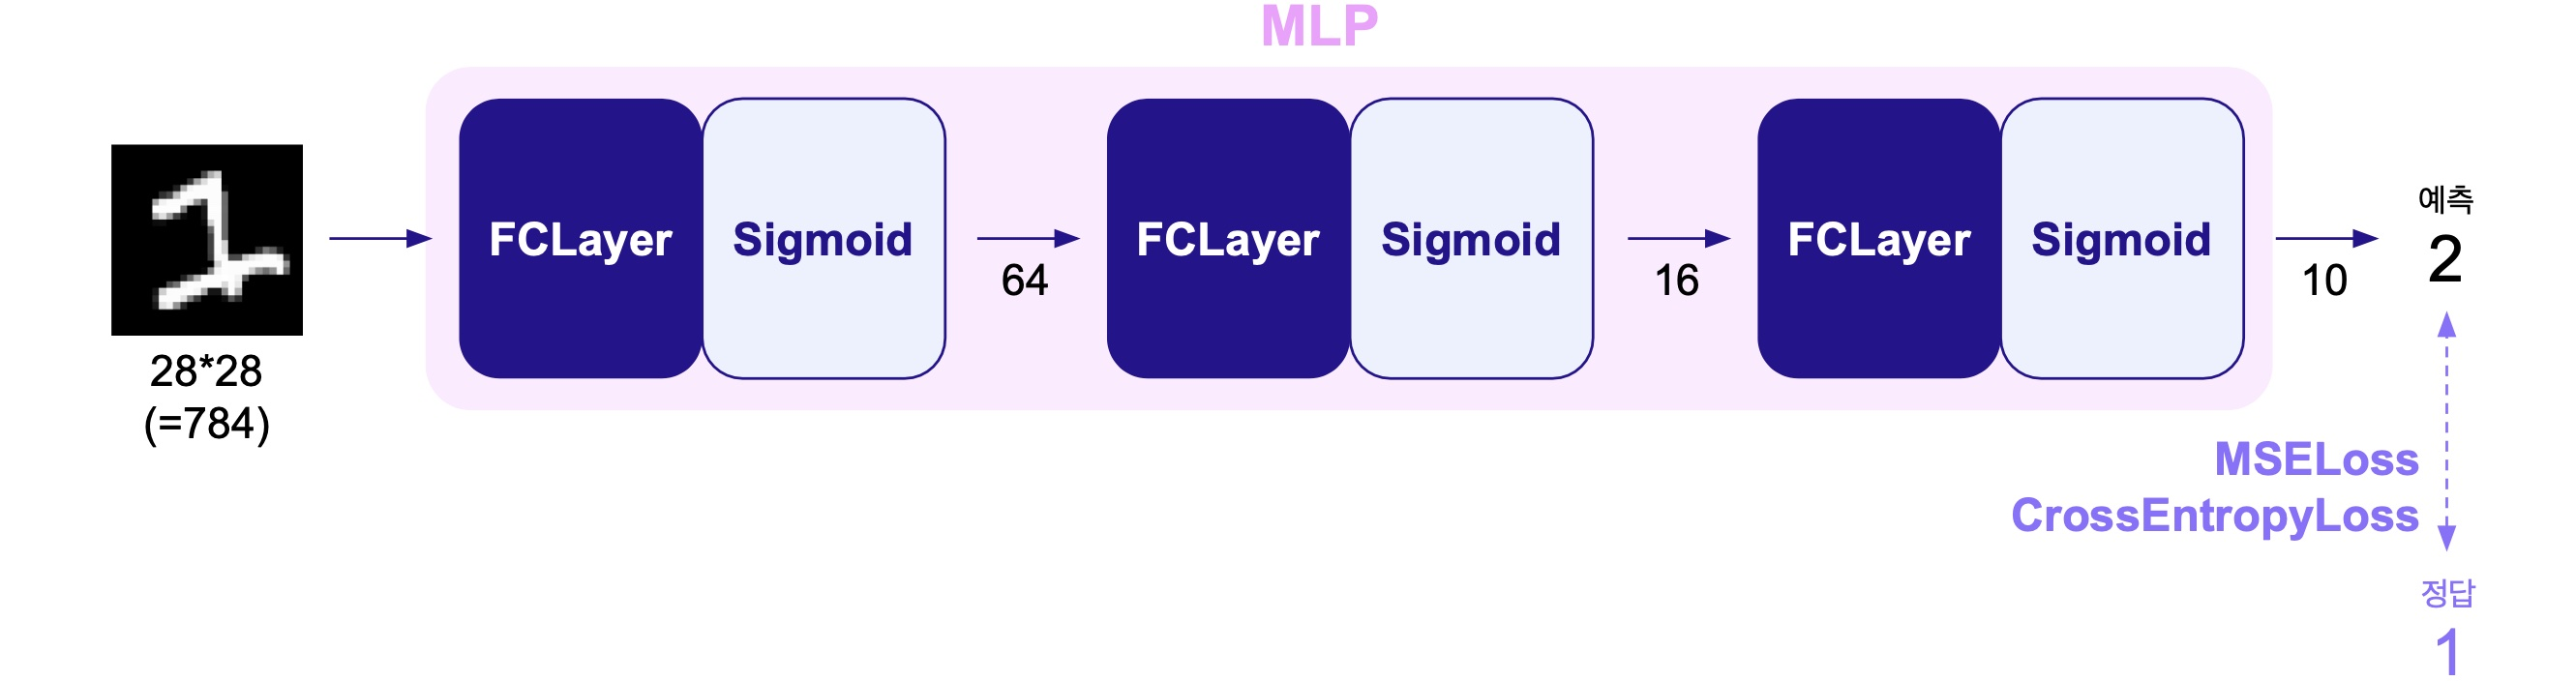


#### 2.4.2. MLP 모델 클래스 구현하기

In [17]:
class MLP():
    '''다층 퍼셉트론(Multi Layer Perceptron, MLP) 모델'''
    def __init__(self, input_size, hidden_size_list, output_size, loss_type='MSE'):
        '''신경망의 구조와 손실 함수 정의
        input_size: 입력 데이터의 차원 수
        hidden_size_list: 은닉층 차원 수의 리스트 (e.g. [100, 100, 100])
        output_size: 출력 데이터의 차원 수
        loss_type: 손실 함수의 종류 ('MSE' or 'CrossEntropy')
        '''

        self.input_size = input_size
        self.hidden_size_list = hidden_size_list
        self.output_size = output_size
        self.hidden_layer_num = len(hidden_size_list)
        self.loss_type = loss_type

        ### 레이어 쌓기 : FCLayer -> Sigmoid -> ... -> FCLayer -> Sigmoid
        # 입력층
        self.layers = [
            FCLayer(input_size, hidden_size_list[0]),
            Sigmoid()
        ]
        # 은닉층
        for idx in range(1, self.hidden_layer_num):
            self.layers.append(FCLayer(hidden_size_list[idx-1], hidden_size_list[idx]))
            self.layers.append(Sigmoid())
        # 출력층
        self.layers.append(FCLayer(hidden_size_list[-1], output_size))
        self.layers.append(Sigmoid())

        # 인자로 받은 `loss_type`에 맞게 손실 함수 레이어 정하기
        if self.loss_type == 'MSE':
            self.loss_layer = MSELoss()
        elif self.loss_type == 'CrossEntropy':
            self.loss_layer = CrossEntropyLoss()
        else:
            self.loss_layer = None


        self.loss = None

    def predict(self, x):
        '''입력값을 받았을 때 순방향 전파를 통한 출력물 산출(예측)'''
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t):
        '''MLP 모델의 순방향 전파'''
        y = self.predict(x)
        self.loss = self.loss_layer.forward(y, t)
        return self.loss

    def backward(self, dout=1):
        '''MLP 모델의 역방향 전파'''
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

#### 2.4.3. MLP 모델 클래스 테스트하기

- 임의의 입출력 데이터와 하이퍼파라미터에 대해 MLP 모델이 에러 없이 작동하는지 확인해봅시다.

In [18]:
x = np.random.randn(5, 2)  # 입력 데이터
y = np.random.randn(5, 1)  # 출력 데이터
print('x =\n', x)

mlp = MLP(input_size=2, hidden_size_list=[10, 5], output_size=1, loss_type='MSE')
print('\nmlp.predict(x) =\n', mlp.predict(x))
print('\nmlp.forward(x, y) =\n', mlp.forward(x, y))
print('\nmlp.backward() =\n', mlp.backward())

x =
 [[-0.51080514 -1.18063218]
 [-0.02818223  0.42833187]
 [ 0.06651722  0.3024719 ]
 [-0.63432209 -0.36274117]
 [-0.67246045 -0.35955316]]

mlp.predict(x) =
 [[0.09179987]
 [0.0957102 ]
 [0.09523428]
 [0.09244939]
 [0.09246448]]

mlp.forward(x, y) =
 1.4714343261962757

mlp.backward() =
 [[-3.38789968e-04 -3.67465930e-04]
 [ 1.17086873e-03  3.64237844e-03]
 [-5.29701613e-05 -1.65101162e-04]
 [-3.87903857e-05  4.80263293e-04]
 [-1.30842487e-04  1.66334466e-03]]


---

### 3. 모델 학습하기

<code>💡 [ 개요 ]  
<p>&emsp;&emsp;&emsp;모델을 선언하기 위한 하이퍼파라미터 세팅부터 SGD를 통해 모델을 학습하는 과정까지를 구현해봅니다.</p>
</code>

- 3.1. 모델 학습 전 준비
- 3.2. 모델 학습하기

#### 3.1. 모델 학습 전 준비

<code>💡 [ 개요 ]  
<p>&emsp;&emsp;&emsp;모델을 학습하기에 앞서, 정확도 계산을 위한 함수를 구현하고
<br>&emsp;&emsp;&emsp;하이퍼파라미터를 세팅하여 모델을 선언하는 과정을 진행합니다.</p>
</code>

- 3.1.1. 정확도 함수 정의하기
- 3.1.2. 하이퍼파라미터 설정하기
- 3.1.3. 모델 생성하기



#### 3.1.1. 정확도 함수 정의하기

In [19]:
# one-hot 인코딩이 되어 있는 값을 다시 라벨로 바꾸어 비교하기 위한 함수
# argmax() 함수를 통해 가장 큰 값(1)의 인덱스를 라벨로 사용하면 됨
# 예를 들어, [0, 0, 1, 0, 0]의 경우, 2번째 인덱스가 가장 큰 값이므로, 라벨은 2가 됨

def accuracy(y, t):
    '''정확도 함수
    :param y: MLP 모델의 예측값
    :param t: 실제값
    :return: 정확도

    Examples
    --------
    >>> y = np.array([[0.1, 0.7, 0.2], [0.9, 0.05, 0.05]])
    >>> t = np.array([[0, 0, 1], [1, 0, 0]])
    >>> accuracy(y, t)
    0.5
    '''
    # TODO: 정확도를 계산하여 리턴하는 코드를 작성해주세요.
    # 힌트 : np.argmax() 함수를 사용하면 가장 큰 값의 인덱스를 리턴받을 수 있습니다.

    # 가장 큰 값의 인덱스를 라벨로 사용
    y_pred = np.argmax(y, axis=1)
    t_label = np.argmax(t, axis=1)

    # 예측 라벨과 실제 라벨이 같은 경우의 개수를 세어 정확도 계산
    correct_predictions = np.sum(y_pred == t_label)

    accuracy = correct_predictions / y.shape[0]
    return accuracy



In [20]:
# 정확도 함수가 잘 작동하는지 테스트
y = np.array([[0.1, 0.2, 0.7], [0.9, 0.05, 0.05], [0.2, 0.2, 0.6]])
t = np.array([[0, 0, 1], [1, 0, 0], [0, 0, 1]])

print('y =\n', y)
print('\nt =\n', t)
print('\naccuracy(y, t) =\n', accuracy(y, t))

y =
 [[0.1  0.2  0.7 ]
 [0.9  0.05 0.05]
 [0.2  0.2  0.6 ]]

t =
 [[0 0 1]
 [1 0 0]
 [0 0 1]]

accuracy(y, t) =
 1.0


#### 3.1.2. 하이퍼파라미터 설정하기

- MSE 손실 함수는 vanishing gradient(8주차 강의 내용) 문제가 생길 수 있으므로
<br>**CE보다 더 큰 값의 학습률을 설정**해주었습니다.
<br>만일 동일한 학습률을 사용한다면 CE의 학습이 MSE보다 훨씬 빠를 것입니다.
<br><br>
- MNIST 데이터셋의 경우 학습이 쉬운 데이터셋이기에 본 실습에서는 빠른 학습을 위해 큰 값으로 정하였으나, <br>**일반적으로 학습률은 소수점 단위(0.01 ~ 0.000001)로 설정되는 매우 작은 값**입니다.

In [21]:
# 네트워크 구조를 정하기 위한 하이퍼파라미터 (784 -> 64 -> 16 -> 10)
n_input = 784
n_hidden = (64,16)
n_output = 10

# 학습에 필요한 하이퍼파라미터
batch_size = 128 # 미니배치 크기
n_epochs = 30 # 몇 epoch 학습할지
print_every = 1 # 몇 epoch마다 정확도를 출력할지 결정
learning_rate_mse = 3 # 학습률 (MSE)
learning_rate_ce = 0.5 # 학습률 (Cross Entropy)

#### 3.1.3. 모델 생성하기

- MSE와 CE의 결과를 비교하기 위해 두 개의 다른 모델을 생성합니다.

In [22]:
# MSE 손실 함수를 사용하는 MLP 모델
mlp_mse = MLP(n_input, n_hidden, n_output, loss_type='MSE')

# Cross Entropy 손실 함수를 사용하는 MLP 모델
mlp_ce = MLP(n_input, n_hidden, n_output, loss_type='CrossEntropy')

### 3.2. 모델 학습하기

<code>💡 [ 개요 ]
<p>&emsp;&emsp;&emsp;3.1에서 선언한 모델을 SGD를 통해 학습시키는 과정을 진행합니다.</p>
</code>

- 3.2.1. 모델 학습하기

#### 3.2.1. 모델 학습하기

In [23]:
def training(model, learning_rate, X_train, y_train, X_test, y_test):
    '''모델 학습 함수'''
    training_errors, training_accs = [], [] # 학습 손실 및 정확도
    test_errors, test_accs = [], []         # 테스트 손실 및 정확도

    # 학습 과정 : n_epochs만큼 반복
    for epoch in tqdm(range(n_epochs)):
        # 학습 데이터를 랜덤하게 섞음
        idx = np.random.permutation(X_train.shape[0])
        X_train = X_train[idx]
        y_train = y_train[idx]

        # 미니배치 학습
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # 순전파
            model.forward(X_batch, y_batch)

            # 역전파
            model.backward()

            # 모델 파라미터 업데이트
            for layer in model.layers:
                if isinstance(layer, FCLayer):
                    # 가중치와 편향을 업데이트하는 코드를 작성해주세요.
                    # 힌트 1 : W_new = W - learning_rate * dW
                    #         b_new = b - learning_rate * db
                    # 힌트 2 : 가중치와 편향은 layer.W와 layer.b에 저장되어 있습니다.
                    #         각각의 그래디언트는 layer.dW와 layer.db에 저장되어 있습니다.
                    layer.W -= learning_rate * layer.dW  # TODO: 가중치 업데이트
                    layer.b -= learning_rate * layer.db  # TODO: 편향 업데이트

        # 학습 과정 출력 : print_every의 배수에 해당할 때마다 출력
        if (epoch+1) % print_every == 0:
            # 모든 학습 데이터에 대한 손실과 정확도 계산
            model.forward(X_train, y_train)
            training_errors.append(model.loss)
            training_accs.append(accuracy(model.predict(X_train), y_train))

            # 모든 테스트 데이터에 대한 손실과 정확도 계산
            model.forward(X_test, y_test)
            test_errors.append(model.loss)
            test_accs.append(accuracy(model.predict(X_test), y_test))

            # 학습 과정 출력
            print(f'[Epoch {epoch+1}/{n_epochs}] Train Loss = {training_errors[-1]:.4f} | '
                  f'Train Acc = {training_accs[-1]*100:.2f}% | '
                  f'Test Loss = {test_errors[-1]:.4f} | Test Acc = {test_accs[-1]*100:.2f}%')

    return np.asarray([training_errors, test_errors, training_accs, test_accs])

In [24]:
# MSE 손실 함수를 사용하는 모델 학습
training_result_mse = training(mlp_mse, learning_rate_mse, X_train, y_train, X_test, y_test)

  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch 1/30] Train Loss = 0.2642 | Train Acc = 83.52% | Test Loss = 0.2548 | Test Acc = 84.25%
[Epoch 2/30] Train Loss = 0.1832 | Train Acc = 88.44% | Test Loss = 0.1793 | Test Acc = 88.67%
[Epoch 3/30] Train Loss = 0.1553 | Train Acc = 90.11% | Test Loss = 0.1537 | Test Acc = 90.36%
[Epoch 4/30] Train Loss = 0.1314 | Train Acc = 91.72% | Test Loss = 0.1355 | Test Acc = 91.28%
[Epoch 5/30] Train Loss = 0.1176 | Train Acc = 92.64% | Test Loss = 0.1261 | Test Acc = 91.95%
[Epoch 6/30] Train Loss = 0.1086 | Train Acc = 93.25% | Test Loss = 0.1185 | Test Acc = 92.42%
[Epoch 7/30] Train Loss = 0.0998 | Train Acc = 93.82% | Test Loss = 0.1136 | Test Acc = 92.60%
[Epoch 8/30] Train Loss = 0.0925 | Train Acc = 94.32% | Test Loss = 0.1068 | Test Acc = 93.07%
[Epoch 9/30] Train Loss = 0.0907 | Train Acc = 94.48% | Test Loss = 0.1076 | Test Acc = 93.04%
[Epoch 10/30] Train Loss = 0.0807 | Train Acc = 95.08% | Test Loss = 0.0995 | Test Acc = 93.61%
[Epoch 11/30] Train Loss = 0.0772 | Train Acc = 9

In [25]:
# Cross Entropy 손실 함수를 사용하는 모델 학습
training_result_ce = training(mlp_ce, learning_rate_ce, X_train, y_train, X_test, y_test)

  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch 1/30] Train Loss = 1.2817 | Train Acc = 78.35% | Test Loss = 1.2592 | Test Acc = 79.07%
[Epoch 2/30] Train Loss = 0.9221 | Train Acc = 85.28% | Test Loss = 0.9070 | Test Acc = 85.67%
[Epoch 3/30] Train Loss = 0.7580 | Train Acc = 88.09% | Test Loss = 0.7579 | Test Acc = 87.85%
[Epoch 4/30] Train Loss = 0.6576 | Train Acc = 89.78% | Test Loss = 0.6735 | Test Acc = 89.48%
[Epoch 5/30] Train Loss = 0.5894 | Train Acc = 90.89% | Test Loss = 0.6122 | Test Acc = 90.49%
[Epoch 6/30] Train Loss = 0.5411 | Train Acc = 91.71% | Test Loss = 0.5706 | Test Acc = 91.30%
[Epoch 7/30] Train Loss = 0.5020 | Train Acc = 92.35% | Test Loss = 0.5382 | Test Acc = 91.67%
[Epoch 8/30] Train Loss = 0.4738 | Train Acc = 92.78% | Test Loss = 0.5154 | Test Acc = 92.13%
[Epoch 9/30] Train Loss = 0.4426 | Train Acc = 93.34% | Test Loss = 0.4928 | Test Acc = 92.31%
[Epoch 10/30] Train Loss = 0.4239 | Train Acc = 93.69% | Test Loss = 0.4703 | Test Acc = 92.66%
[Epoch 11/30] Train Loss = 0.3990 | Train Acc = 9

---

### 4. 결과 시각화하기

<code>💡 [ 개요 ]
<p>&emsp;&emsp;&emsp;학습되는 과정에서 수집한 모델의 성능과 최종 결과를 시각화합니다.</p>
</code>

- 4.1. 학습 과정 시각화하기
- 4.2. 최종 결과 시각화하기

#### 4.1. 학습 과정 시각화하기

<code>💡 [ 개요 ]
<p>&emsp;&emsp;&emsp;모델이 잘 학습되고 있었는지를 각 epoch에 대해 선그래프로 도식화해봅시다.</p>
<p>&emsp;&emsp;&emsp;딥러닝 분야에서는 이를 학습 곡선(learning curve)이라고 부르고 있습니다.</p>
</code>

- 4.1.1. 학습 곡선 그리기 - MSE Loss
- 4.1.2. 학습 곡선 그리기 - CE Loss
- 4.1.3. 학습 곡선 그리기 - 두 모델의 정확도 비교

#### 4.1.1. 학습 곡선 그리기 - MSE Loss

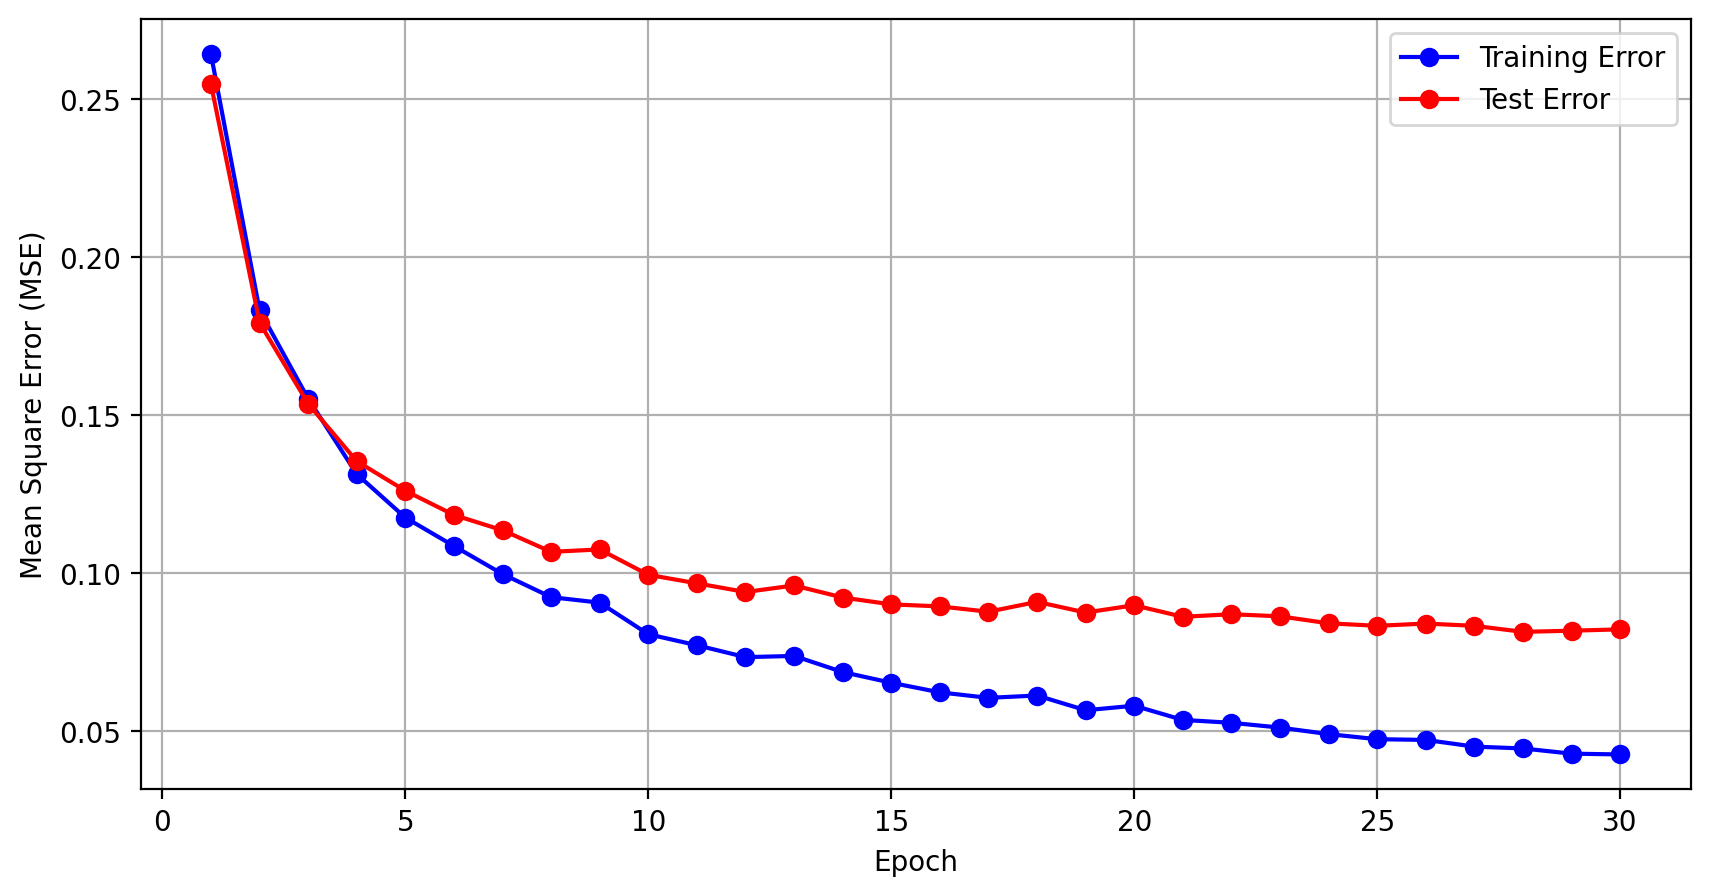

In [26]:
# MSE 손실 함수를 통해 학습한 모델의 학습 및 테스트 에러 시각화하기
plt.figure(figsize=(10, 5))
plt.plot(range(1,n_epochs+1), training_result_mse[0], 'bo-', label='Training Error')
plt.plot(range(1,n_epochs+1), training_result_mse[1], 'ro-', label='Test Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error (MSE)')
plt.grid(True)
plt.legend()
plt.show()

#### 4.1.2. 학습 곡선 그리기 - CE Loss

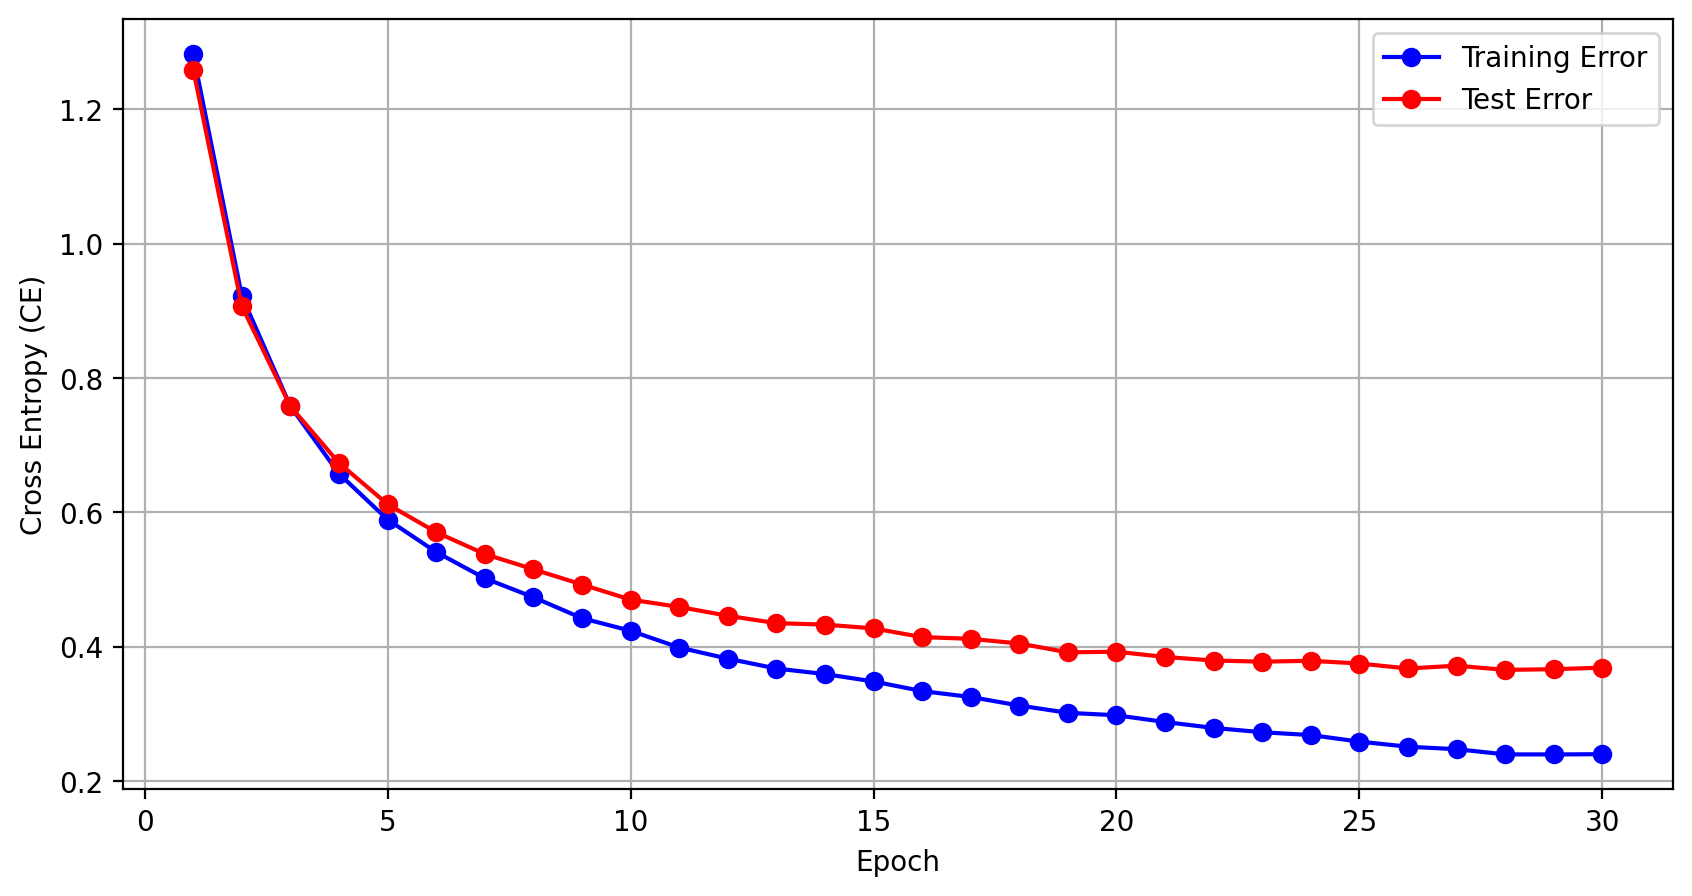

In [27]:
# Cross Entropy 손실 함수를 통해 학습한 모델의 학습 및 테스트 에러 시각화하기
plt.figure(figsize=(10, 5))
plt.plot(range(1,n_epochs+1), training_result_ce[0], 'bo-', label='Training Error')
plt.plot(range(1,n_epochs+1), training_result_ce[1], 'ro-', label='Test Error')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy (CE)')
plt.grid(True)
plt.legend()
plt.show()

#### 4.1.3. 학습 곡선 그리기 - 두 모델의 정확도 비교

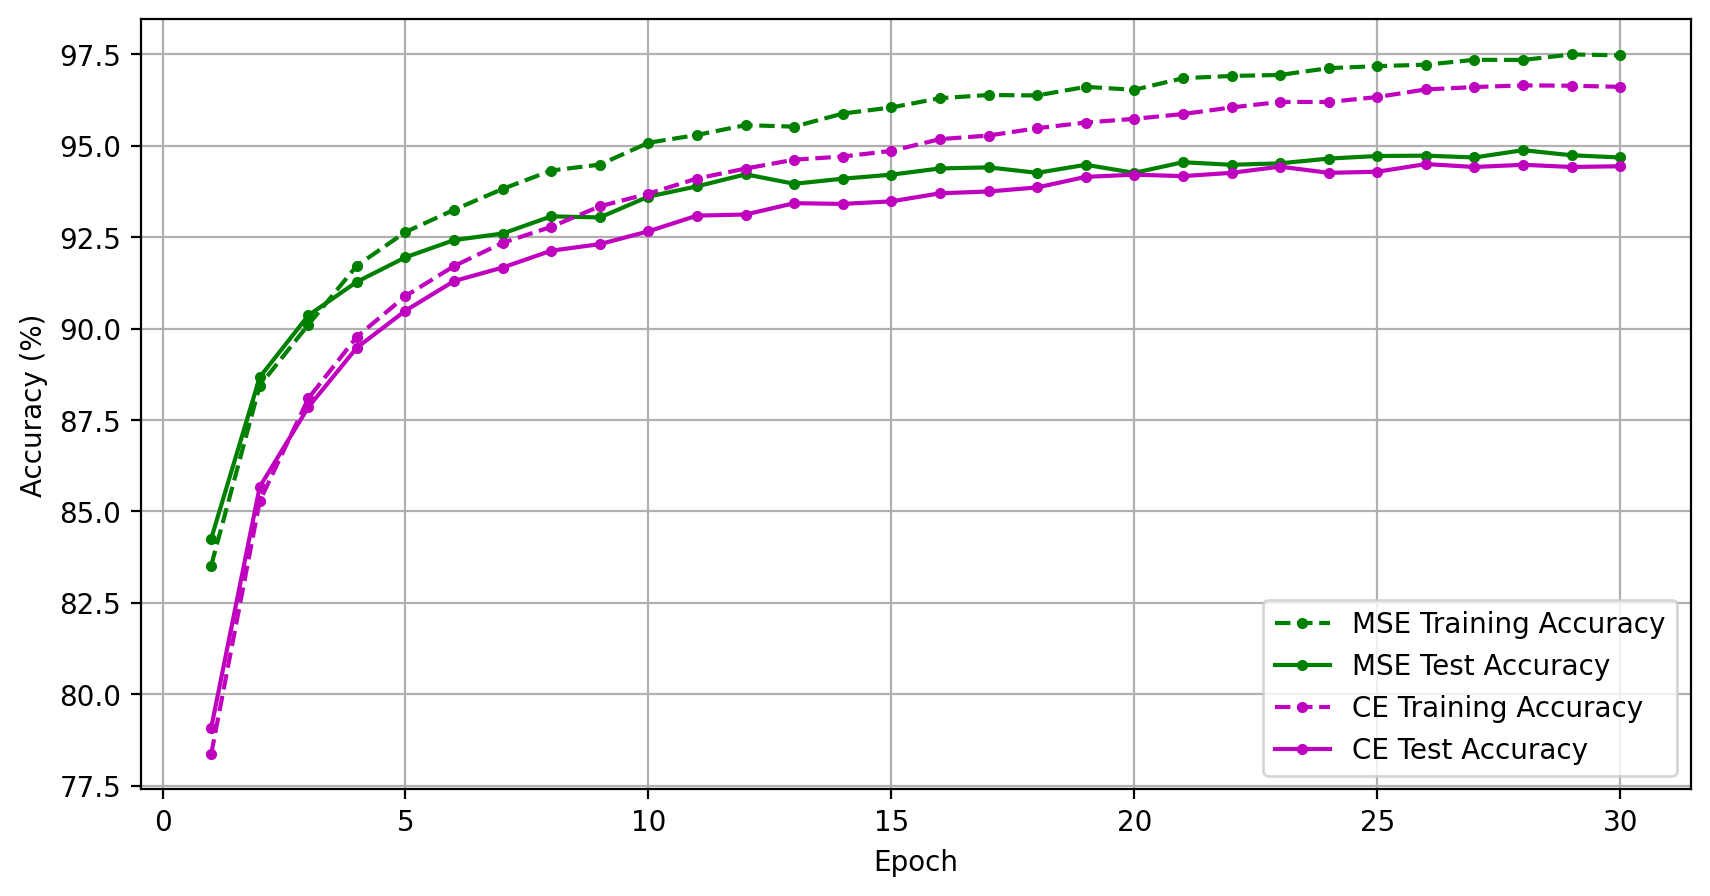

In [28]:
# 두 모델의 학습 및 테스트 정확도 시각화하기
plt.figure(figsize=(10, 5))
plt.plot(range(1,n_epochs+1), training_result_mse[2]*100, 'g.--', label='MSE Training Accuracy')
plt.plot(range(1,n_epochs+1), training_result_mse[3]*100, 'g.-', label='MSE Test Accuracy')
plt.plot(range(1,n_epochs+1), training_result_ce[2]*100, 'm.--', label='CE Training Accuracy')
plt.plot(range(1,n_epochs+1), training_result_ce[3]*100, 'm.-', label='CE Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.show()

#### 4.2. 최종 결과 시각화하기

<code>💡 [ 개요 ]
<p>&emsp;&emsp;&emsp;데이터 샘플 일부를 추출하여 시각화함으로써 모델의 성능에 대한 보다 직관적인 이해를 할 수 있습니다.</p>
<p>&emsp;&emsp;&emsp;본 실습에서는 간단하게 25개의 데이터 샘플에 대해 실제값과 예측값을 프린트해봅니다.
<br>&emsp;&emsp;&emsp;(CE 손실 함수를 사용한 모델을 사용)</p>
</code>

- 4.2.1. 임의의 데이터 샘플 시각화하기
- 4.2.2. 정답과 다르게 예측한 데이터 샘플 시각화하기

#### 4.2.1. 임의의 데이터 샘플 시각화하기

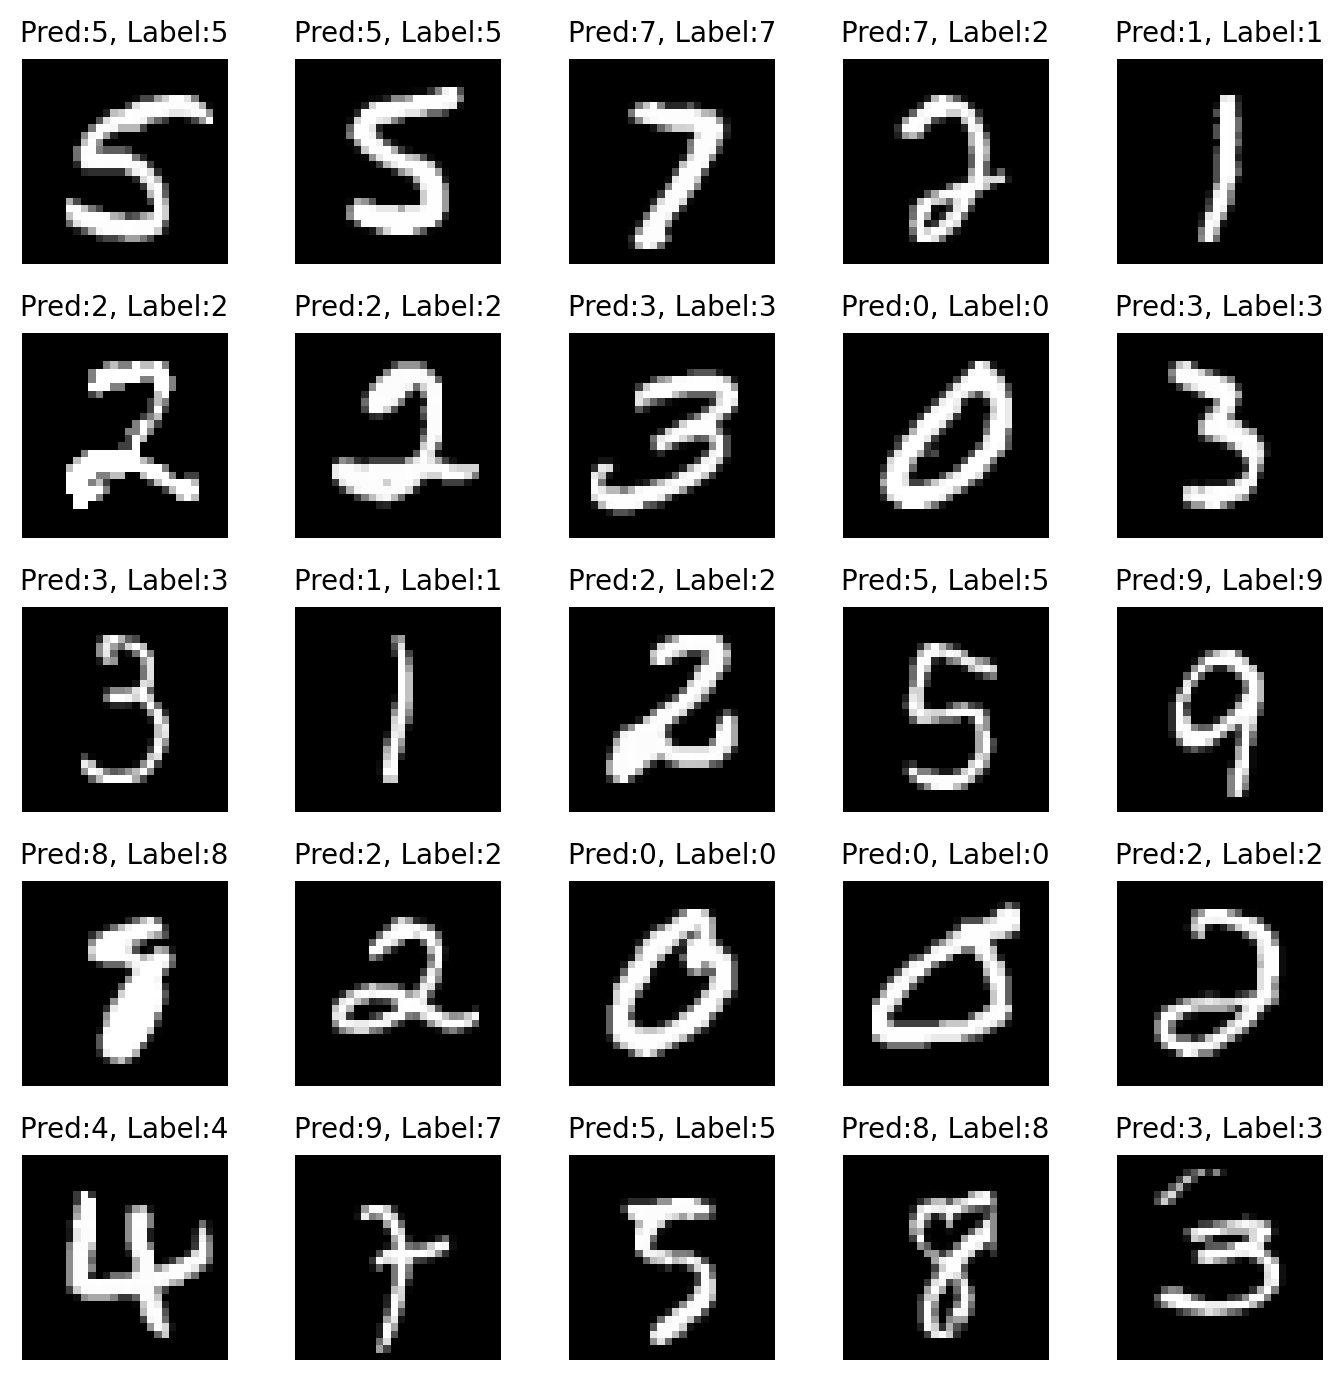

In [29]:
# 25개의 임의의 테스트 데이터에 대한 분류 결과 시각화하기
n_sample = 25  # number of samples

# 테스트셋으로부터 임의의 25개의 이미지 추출 및 이에 대응하는 라벨과 모델 결과 생성
sample_indices = np.random.choice(len(y_test), n_sample, replace=False)
sample_images = X_test[sample_indices].reshape((-1,28,28))
sample_labels = np.argmax(y_test[sample_indices], axis=1)
sample_pred = np.argmax(mlp_mse.predict(X_test[sample_indices]), axis=1)

# 7x7 사이즈의 새로운 figure 생성
plt.figure(figsize=(7,7))
for idx in range(n_sample):
    # 5x5 그리드의 (idx+1)번째 위치에 그래이스케일 이미지를 출력
    # 타이틀로는 모델의 예측값과 실제값을 출력
    plt.subplot(5, 5, idx+1)
    plt.imshow(sample_images[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(sample_pred[idx], sample_labels[idx]), fontsize=10)

plt.tight_layout()
plt.show()


#### 4.2.2. 정답과 다르게 예측한 데이터 샘플 시각화하기

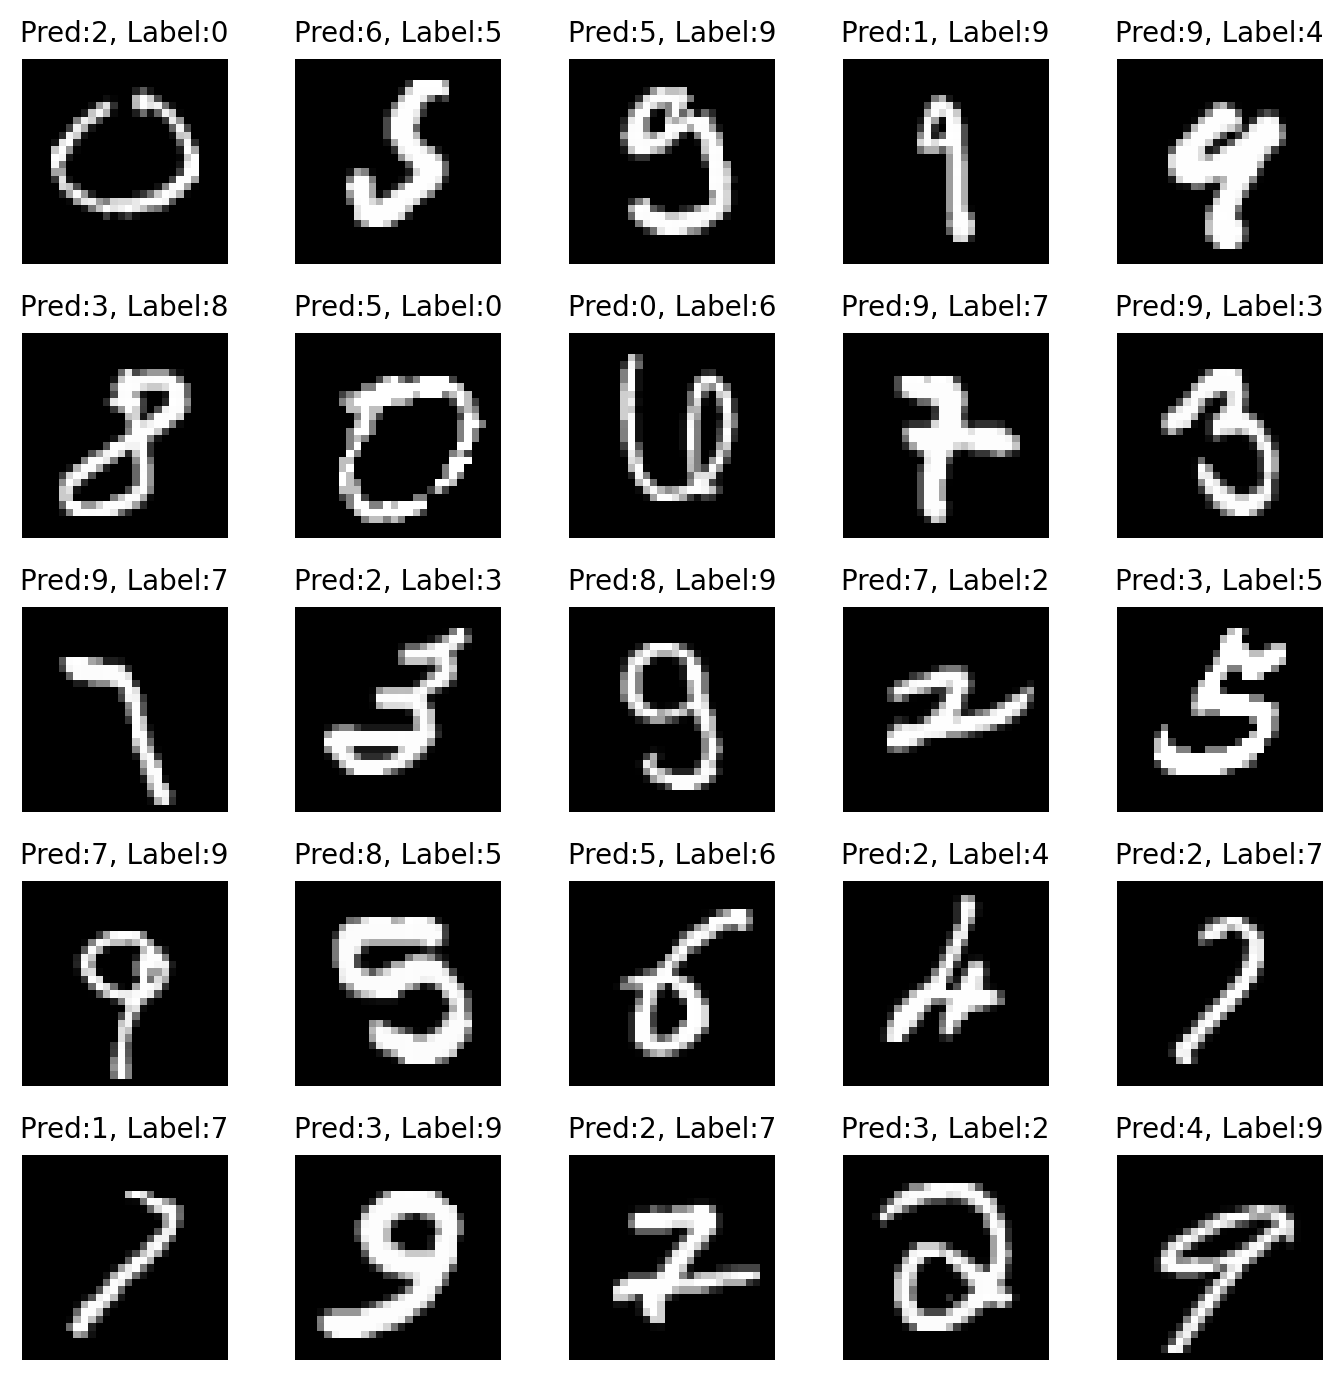

In [30]:
# 25개의 오답 데이터에 대한 분류 결과 시각화하기
n_sample = 25  # number of samples

# 테스트셋으로부터 틀린 25개의 이미지 추출 및 이에 대응하는 라벨과 모델 결과 생성
pred_result = np.argmax(mlp_mse.predict(X_test), axis=1)
wrong_indices = np.where(pred_result != np.argmax(y_test, axis=1))[0]
sample_indices = np.random.choice(wrong_indices, n_sample, replace=False)
sample_images = X_test[sample_indices].reshape((-1,28,28))
sample_labels = np.argmax(y_test[sample_indices], axis=1)
sample_pred = pred_result[sample_indices]

# 7x7 사이즈의 새로운 figure 생성
plt.figure(figsize=(7,7))
for idx in range(n_sample):
    # 5x5 그리드의 (idx+1)번째 위치에 그래이스케일 이미지를 출력
    # 타이틀로는 모델의 예측값과 실제값을 출력
    plt.subplot(5, 5, idx+1)
    plt.imshow(sample_images[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(sample_pred[idx], sample_labels[idx]), fontsize=10)

plt.tight_layout()
plt.show()